In [1]:
!pip install modal-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 1.8 MB/s eta 0:00:00 0:00:01


In [2]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 21.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitz

In [3]:
!pip install modAL

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 950.1 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.6/467.6 kB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.7 MB/s eta 0:00:00
  Created wheel for grpclib: filename=grpclib-0.4.7-py3-none-any.whl size=76220 sha256=a02da88feb2a67f5e9e0d5b3c4b150a33f8a58a8f8f2f82f39cad37cb6daaaeb
  Stored in directory: /root/.cache/pip/wheels/05/c0/1c/3d807409d0c67efeab2949832ba409205b1b6fe03f739ae4c1
Successfully built grpclib


In [157]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling, classifier_uncertainty
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [159]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0


y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [160]:
len(X_train)

50000

CNN model

In [161]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Input , MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical

def create_model():
    model = Sequential()
    model.add(Input((32, 32, 3)))

    # First convolutional block
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Second convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Flatten the output for the fully connected layers
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy' , 'recall' , 'precision' , 'f1_score'])

    # Print the model summary
    model.summary()
    return model

In [162]:
# Use predict instead of predict_proba
def predict_proba(self, X, **predict_proba_kwargs):
    return self.estimator.predict(X, **predict_proba_kwargs)
ActiveLearner.predict_proba = predict_proba

# ***Random Sampling:***

prepare data

In [168]:
#labeled data
initial_idx = slice(400)
X_initial_1 = X_train[initial_idx]
y_initial_1 = y_train[initial_idx]


#unlabeled data
X_pool_1 = np.delete(X_train, initial_idx, axis=0)
y_pool_1 = np.delete(y_train, initial_idx, axis=0)

pool_indices = np.arange(len(X_pool_1))

In [169]:
def random_sampling(classifier, X_pool_1):
    n_samples = len(X_pool_1)
    query_indices = np.random.choice(range(n_samples), size=1500, replace=False)
    return query_indices, X_pool_1[query_indices]

In [170]:
print(y_train.shape)

(50000, 10)


In [171]:
learner = ActiveLearner(
    estimator=create_model(),
    query_strategy = random_sampling,
    X_training=X_initial_1,
    y_training=y_initial_1
)

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_68 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_89          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 459ms/step - accuracy: 0.2036 - f1_score: 0.1792 - loss: 3.1698 - precision: 0.2285 - recall: 0.1387


60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.3224 - f1_score: 0.3096 - loss: 2.6344 - precision: 0.3639 - recall: 0.2596
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.3798 - f1_score: 0.3727 - loss: 2.0307 - precision: 0.4546 - recall: 0.2876
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.4628 - f1_score: 0.4545 - loss: 1.6939 - precision: 0.5514 - recall: 0.3733
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5166 - f1_score: 0.5101 - loss: 1.4868 - precision: 0.6133 - recall: 0.4160
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.5730 - f1_score: 0.5683 - loss: 1.2405 - precision: 0.6733 - recall: 0.4754
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
294/294 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6215 - f1_score: 0.6184 - loss: 1.0959 - precision: 0.727

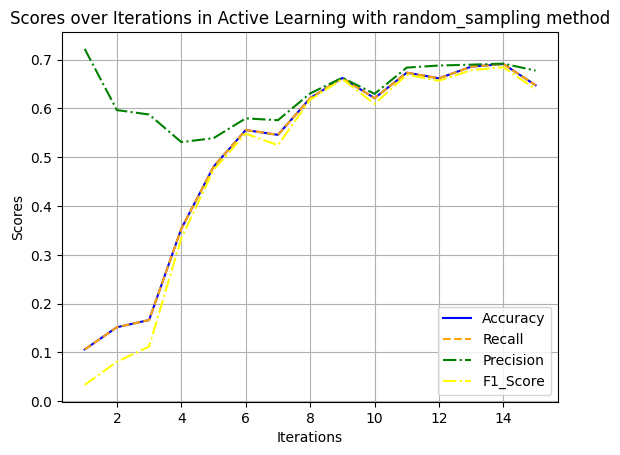

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns

n_queries = 15
accuracies = [] 
recalls  = []
precisions = []
f1S = []

# Active learning loop
for _ in range(n_queries):
    query_idx, query_instance = learner.query(X_pool_1)
    X_query, y_query = X_pool_1[query_idx], y_pool_1[query_idx]

    
    learner.teach(X=X_query, y=y_query)
    
    X_pool_1 = np.delete(X_pool_1, query_idx, axis=0)
    y_pool_1 = np.delete(y_pool_1, query_idx, axis=0)
    print(len(X_query))
    y_pred = learner.predict(X_test)
    y_pred = np.argmax(y_pred , axis = 1)
    
    
    acc = accuracy_score(np.argmax(y_test , axis = 1), y_pred)
    accuracies.append(acc)
    recalls.append(recall_score(np.argmax(y_test , axis = 1), y_pred, average='weighted', zero_division=1))
    precisions.append(precision_score(np.argmax(y_test , axis = 1), y_pred, average='weighted', zero_division=1))
    f1S.append(f1_score(np.argmax(y_test , axis = 1), y_pred, average='weighted', zero_division=1))

    # Evaluate the model periodically
    if (_ + 1) % 10 == 0:
        print(f"Query {_+1}, Accuracy: {acc}")
        
plt.plot(range(1, n_queries + 1), accuracies, label='Accuracy', linestyle='-', color='blue')
plt.plot(range(1, n_queries + 1), recalls, label='Recall', linestyle='--', color='orange')
plt.plot(range(1, n_queries + 1), precisions, label='Precision', linestyle='-.', color='green')
plt.plot(range(1, n_queries + 1), f1S, label='F1_Score', linestyle='-.', color='yellow')

plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Scores over Iterations in Active Learning with random_sampling method')
plt.legend()
plt.grid(True)
plt.show()

In [173]:
y_pred = learner.predict(X_test)
y_pred = np.argmax(y_pred , axis = 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [174]:
y_test = np.argmax(y_test , axis = 1)

In [175]:
y_test.shape

(10000,)

In [176]:
y_pred = learner.predict(X_test)
y_pred = np.argmax(y_pred , axis = 1)
acc = accuracy_score(y_test, y_pred)
accuracies.append(acc)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
f1 =  f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.6476
Precision: 0.6776366683841841
Recall: 0.6476
F1-score: 0.6392643179438753


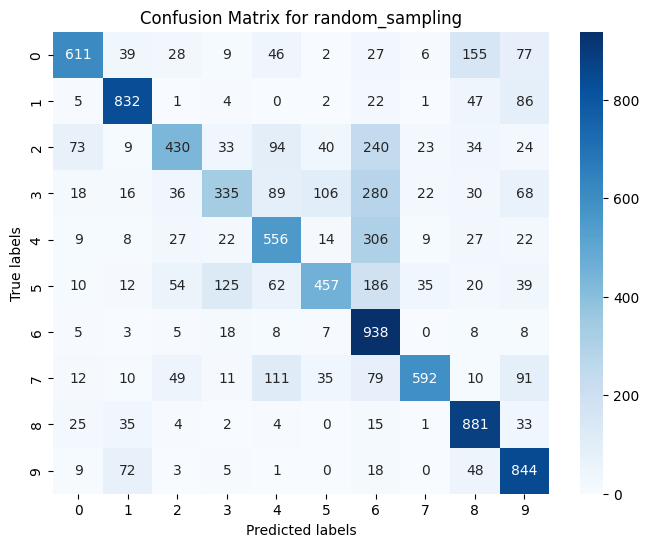

In [179]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have y_test and y_pred

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for random_sampling')
plt.show()

# ***margin_sampling:***

prepare data

In [191]:
#labeled data
initial_idx = slice(400)
X_initial_2 = X_train[initial_idx]
y_initial_2 = y_train[initial_idx]


#unlabeled data
X_pool_2 = np.delete(X_train, initial_idx, axis=0)
y_pool_2 = np.delete(y_train, initial_idx, axis=0)

In [192]:
learner = ActiveLearner(
    estimator=create_model(),
    query_strategy = margin_sampling,
    X_training=X_initial_2,
    y_training=y_initial_2
)

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_84 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_105         │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_106         │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_107         │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_108         │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_109         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 461ms/step - accuracy: 0.1310 - f1_score: 0.1229 - loss: 3.5664 - precision: 0.1595 - recall: 0.0972


1550/1550 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.3055 - f1_score: 0.2933 - loss: 2.8102 - precision: 0.3479 - recall: 0.2455
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.3783 - f1_score: 0.3652 - loss: 2.0391 - precision: 0.4618 - recall: 0.2930
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.4645 - f1_score: 0.4526 - loss: 1.6919 - precision: 0.5468 - recall: 0.3549
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5108 - f1_score: 0.4951 - loss: 1.4466 - precision: 0.5946 - recall: 0.4121
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.5669 - f1_score: 0.5

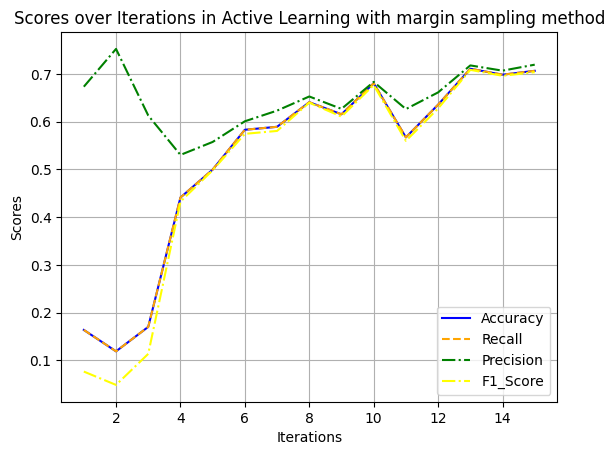

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns
n_queries = 15
accuracies = [] 
recalls  = []
precisions = []
f1S = []

# Active learning loop
for _ in range(n_queries):
    query_idx, query_instance = learner.query(X_pool_2, n_instances=1500)
    X_query, y_query = X_pool_2[query_idx], y_pool_2[query_idx]

    
    learner.teach(X=X_query, y=y_query)
    
    X_pool_2 = np.delete(X_pool_2, query_idx, axis=0)
    y_pool_2 = np.delete(y_pool_2, query_idx, axis=0)
    print(len(X_query))
    y_pred = learner.predict(X_test)
    y_pred = np.argmax(y_pred , axis = 1)
    
    
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    recalls.append(recall_score(y_test, y_pred, average='weighted', zero_division=1))
    precisions.append(precision_score(y_test, y_pred, average='weighted', zero_division=1))
    f1S.append(f1_score(y_test, y_pred, average='weighted', zero_division=1))

    # Evaluate the model periodically
    if (_ + 1) % 10 == 0:
        print(f"Query {_+1}, Accuracy: {acc}")
        
plt.plot(range(1, n_queries + 1), accuracies, label='Accuracy', linestyle='-', color='blue')
plt.plot(range(1, n_queries + 1), recalls, label='Recall', linestyle='--', color='orange')
plt.plot(range(1, n_queries + 1), precisions, label='Precision', linestyle='-.', color='green')
plt.plot(range(1, n_queries + 1), f1S, label='F1_Score', linestyle='-.', color='yellow')

plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Scores over Iterations in Active Learning with margin sampling method')
plt.legend()
plt.grid(True)
plt.show()

In [194]:
y_pred = learner.predict(X_test)
y_pred = np.argmax(y_pred , axis = 1)
acc = accuracy_score(y_test, y_pred)
accuracies.append(acc)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
f1 =  f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.7064
Precision: 0.7192999612325794
Recall: 0.7064
F1-score: 0.7036291859350785


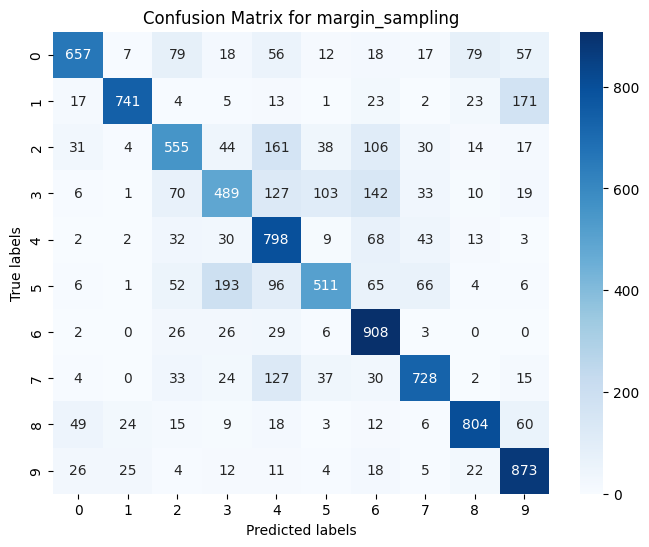

In [195]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for margin_sampling')
plt.show()

# ***entropy_sampling:***

prepare data

In [202]:
#labeled data
initial_idx = slice(400)
X_initial_3 = X_train[initial_idx]
y_initial_3 = y_train[initial_idx]


#unlabeled data
X_pool_3 = np.delete(X_train, initial_idx, axis=0)
y_pool_3 = np.delete(y_train, initial_idx, axis=0)

In [203]:
learner = ActiveLearner(
    estimator=create_model(),
    query_strategy = entropy_sampling,
    X_training=X_initial_3,
    y_training=y_initial_3
)

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_92 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_117         │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_118         │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_119         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 482ms/step - accuracy: 0.1560 - f1_score: 0.1440 - loss: 3.5350 - precision: 0.1587 - recall: 0.0972


1550/1550 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.3645 - f1_score: 0.2981 - loss: 2.4851 - precision: 0.4196 - recall: 0.2974
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.4265 - f1_score: 0.3693 - loss: 1.9493 - precision: 0.5169 - recall: 0.3504
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4923 - f1_score: 0.4563 - loss: 1.6822 - precision: 0.5975 - recall: 0.3910
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5628 - f1_score: 0.5090 - loss: 1.3573 - precision: 0.6537 - recall: 0.4541
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6075 - f1_score: 0.5

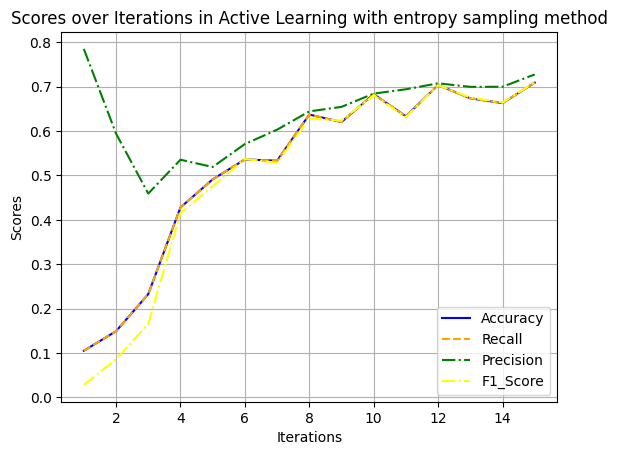

In [204]:
n_queries = 15
accuracies = [] 
recalls  = []
precisions = []
f1S = []

# Active learning loop
for _ in range(n_queries):
    query_idx, query_instance = learner.query(X_pool_3, n_instances=1500)
    X_query, y_query = X_pool_3[query_idx], y_pool_3[query_idx]

    
    learner.teach(X=X_query, y=y_query)
    
    X_pool_3 = np.delete(X_pool_3, query_idx, axis=0)
    y_pool_3 = np.delete(y_pool_3, query_idx, axis=0)
    print(len(X_query))
    y_pred = learner.predict(X_test)
    y_pred = np.argmax(y_pred , axis = 1)
    
    
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    recalls.append(recall_score(y_test, y_pred, average='weighted', zero_division=1))
    precisions.append(precision_score(y_test, y_pred, average='weighted', zero_division=1))
    f1S.append(f1_score(y_test, y_pred, average='weighted', zero_division=1))

    # Evaluate the model periodically
    if (_ + 1) % 10 == 0:
        print(f"Query {_+1}, Accuracy: {acc}")
        
plt.plot(range(1, n_queries + 1), accuracies, label='Accuracy', linestyle='-', color='blue')
plt.plot(range(1, n_queries + 1), recalls, label='Recall', linestyle='--', color='orange')
plt.plot(range(1, n_queries + 1), precisions, label='Precision', linestyle='-.', color='green')
plt.plot(range(1, n_queries + 1), f1S, label='F1_Score', linestyle='-.', color='yellow')
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Scores over Iterations in Active Learning with entropy sampling method')
plt.legend()
plt.grid(True)

plt.show()

In [205]:
y_pred = learner.predict(X_test)
y_pred = np.argmax(y_pred , axis = 1)
acc = accuracy_score(y_test, y_pred)
accuracies.append(acc)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
f1 =  f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.7092
Precision: 0.7277882231483914
Recall: 0.7092
F1-score: 0.709619177381679


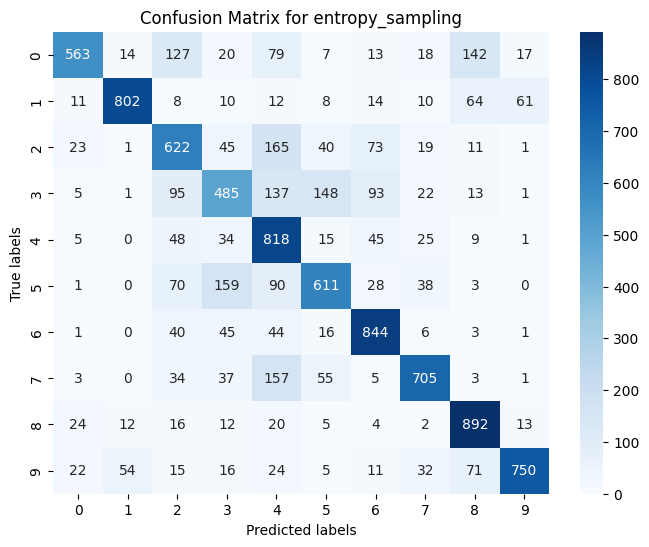

In [206]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have y_test and y_pred

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for entropy_sampling')
plt.show()

# ***uncertainty_sampling (Least Confidence Sampling):***

prepare data

In [209]:
#labeled data
initial_idx = slice(400)
X_initial_4 = X_train[initial_idx]
y_initial_4 = y_train[initial_idx]


#unlabeled data
X_pool_4 = np.delete(X_train, initial_idx, axis=0)
y_pool_4 = np.delete(y_train, initial_idx, axis=0)

In [210]:
from modAL.disagreement import vote_entropy_sampling

learner = ActiveLearner(
    estimator=create_model(),
    query_strategy = uncertainty_sampling,
    X_training=X_initial_4,
    y_training=y_initial_4
)

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_100 (Conv2D)             │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_125         │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_126         │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_127         │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_128         │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_129         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - accuracy: 0.1926 - f1_score: 0.1786 - loss: 3.4721 - precision: 0.2009 - recall: 0.1233


1550/1550 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.3683 - f1_score: 0.2868 - loss: 2.5070 - precision: 0.4383 - recall: 0.3165
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.4203 - f1_score: 0.3836 - loss: 1.9513 - precision: 0.4986 - recall: 0.3338
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.4912 - f1_score: 0.4633 - loss: 1.5928 - precision: 0.5814 - recall: 0.3992
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5753 - f1_score: 0.5405 - loss: 1.2960 - precision: 0.6558 - recall: 0.4831
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.6155 - f1_score: 0.5

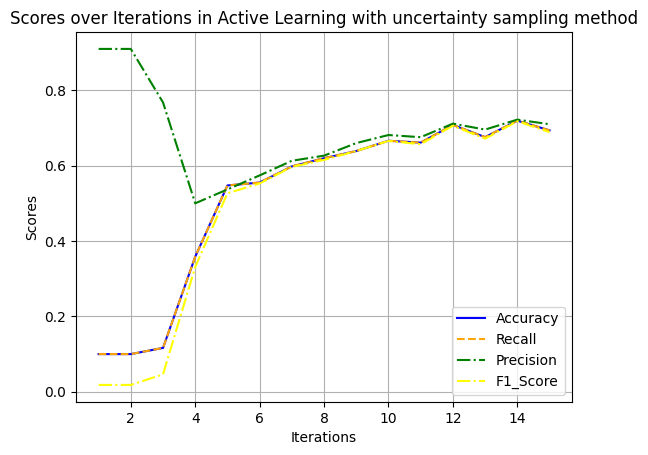

In [211]:
n_queries = 15
accuracies = [] 
recalls  = []
precisions = []
f1S = []

# Active learning loop
for _ in range(n_queries):
    query_idx, query_instance = learner.query(X_pool_4, n_instances=1500)
    X_query, y_query = X_pool_4[query_idx], y_pool_4[query_idx]

    
    learner.teach(X=X_query, y=y_query)
    
    X_pool_4 = np.delete(X_pool_4, query_idx, axis=0)
    y_pool_4 = np.delete(y_pool_4, query_idx, axis=0)
    print(len(X_query))
    y_pred = learner.predict(X_test)
    y_pred = np.argmax(y_pred , axis = 1)
    
    
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    recalls.append(recall_score(y_test, y_pred, average='weighted', zero_division=1))
    precisions.append(precision_score(y_test, y_pred, average='weighted', zero_division=1))
    f1S.append(f1_score(y_test, y_pred, average='weighted', zero_division=1))

    # Evaluate the model periodically
    if (_ + 1) % 10 == 0:
        print(f"Query {_+1}, Accuracy: {acc}")
        
plt.plot(range(1, n_queries + 1), accuracies, label='Accuracy', linestyle='-', color='blue')
plt.plot(range(1, n_queries + 1), recalls, label='Recall', linestyle='--', color='orange')
plt.plot(range(1, n_queries + 1), precisions, label='Precision', linestyle='-.', color='green')
plt.plot(range(1, n_queries + 1), f1S, label='F1_Score', linestyle='-.', color='yellow')

plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Scores over Iterations in Active Learning with uncertainty sampling method')
plt.legend()
plt.grid(True)

plt.show()

In [212]:
y_pred = learner.predict(X_test)
y_pred = np.argmax(y_pred , axis = 1)
acc = accuracy_score(y_test, y_pred)
accuracies.append(acc)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
f1 =  f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.6938
Precision: 0.710132760388487
Recall: 0.6938
F1-score: 0.689101985417653


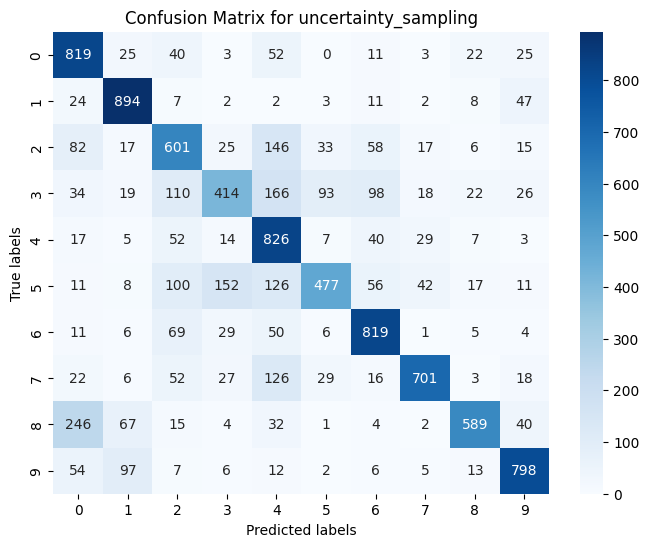

In [213]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have y_test and y_pred

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for uncertainty_sampling')
plt.show()

# ***passive learning: ***

In [214]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [215]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = create_model()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_104 (Conv2D)             │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_130         │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_131         │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_132         │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_133         │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_134         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [216]:
# Train the model
history = model.fit(x_train, y_train, epochs=10)


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.4082 - f1_score: 0.4056 - loss: 1.9315 - precision: 0.4936 - recall: 0.3002
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6562 - f1_score: 0.6546 - loss: 0.9950 - precision: 0.7562 - recall: 0.5519
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7139 - f1_score: 0.7125 - loss: 0.8293 - precision: 0.7984 - recall: 0.6311
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7439 - f1_score: 0.7428 - loss: 0.7319 - precision: 0.8173 - recall: 0.6742
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7705 - f1_score: 0.7703 - loss: 0.6600 - precision: 0.8356 - recall: 0.7112
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7915 - f1_score: 0.7910 - loss: 0.5969 - precision: 0.8502 - recall: 0.7380
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8128 - f1_score: 0.8119 - loss: 0.5374 - precision: 0.8618 - recall

In [222]:
y_test.shape

(10000, 10)

In [223]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred , axis = 1)
y_test = np.argmax(y_test , axis = 1)

acc = accuracy_score(y_test, y_pred)
accuracies.append(acc)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
f1 =  f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.8058
Precision: 0.8052689443403817
Recall: 0.8058
F1-score: 0.8036291470514086


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 800x800 with 0 Axes>

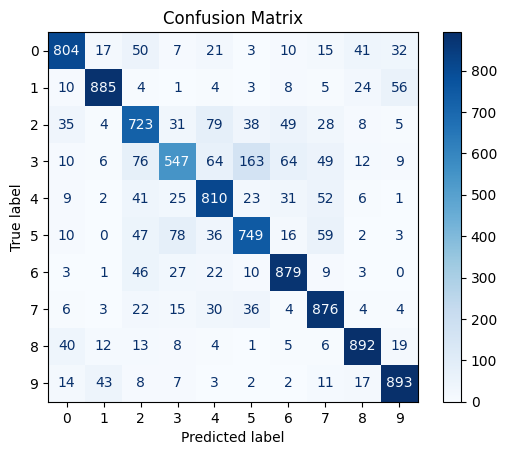

In [224]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_pred = np.argmax(model.predict(x_test), axis=-1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
